In [1]:
# Import relevant libraries
import pandas as pd
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read in data
datam = pd.read_stata('stubhub_panel.dta')
datam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230227 entries, 0 to 2230226
Columns: 161 entries, newgameid to RELSPRICE
dtypes: float32(39), float64(6), int16(21), int32(1), int8(83), object(11)
memory usage: 912.4+ MB


In [3]:
# Original Regression
# xtreg RELSPRICE D3to5-D81plus _I* firstrow secondrow numbrow norow piggy  homerecord* awayrecord* homegameahead homegameback
# homeaheadgtg homebackgtg awaygameahead awaygameback awaybackgtg awayaheadgtg homewildgamebackgtg homewildgameaheadgtg
# awaywildgamebackgtg awaywildgameaheadgtg homewildgameback homewildgameahead awaywildgameback awaywildgameahead EBlist
# EBalllist EBregpnlist EBregplist SHlist SHalllist SHregpnlist SHregplist EBlistdum EBalllistdum EBregpnlistdum EBregplistdum
# EBlist2 EBalllist2 EBregpnlist2 EBregplist2 SHlist2 SHalllist2 SHregpnlist2 SHregplist2, fe i(gameregpfe)

In [4]:
# Generate list of data from original regressions
var_list = 'RELSPRICE firstrow secondrow numbrow norow piggy homegameahead homegameback homeaheadgtg homebackgtg awaygameahead awaygameback awaybackgtg awayaheadgtg homewildgamebackgtg homewildgameaheadgtg awaywildgamebackgtg awaywildgameaheadgtg homewildgameback homewildgameahead awaywildgameback awaywildgameahead EBlist EBregpnlist EBregplist SHlist SHalllist SHregpnlist SHregplist EBlistdum EBalllistdum EBregpnlistdum EBregplistdum EBalllist2 EBregpnlist2 EBregplist2 SHlist2 SHalllist2 SHregpnlist2 SHregplist2 home away propmaxatt'
var_list = var_list.split()
var_list.extend(['D3to5', 'D6to8', 'D9to11', 'D12to14', 'D15to17', 'D18to20', 'D21to23', 'D24to26', 'D27to29', 'D30to32', 'D33to35', 'D36to38', 'D39to41', 'D42to44', 'D45to47', 'D48to50', 'D51to55', 'D56to60', 'D61to70', 'D71to80', 'D81plus'])
var_list.extend(['_Inumb_2', '_Inumb_3', '_Inumb_4', '_Inumb_5', '_Inumb_6', '_Iupto_1', '_InumXupt_2_1', '_InumXupt_3_1', '_InumXupt_4_1', '_InumXupt_5_1', '_InumXupt_6_1'])
var_list.extend(['homerecord', 'gamehomerecord', 'awayrecord', 'gameawayrecord'])
print(list(var_list))

['RELSPRICE', 'firstrow', 'secondrow', 'numbrow', 'norow', 'piggy', 'homegameahead', 'homegameback', 'homeaheadgtg', 'homebackgtg', 'awaygameahead', 'awaygameback', 'awaybackgtg', 'awayaheadgtg', 'homewildgamebackgtg', 'homewildgameaheadgtg', 'awaywildgamebackgtg', 'awaywildgameaheadgtg', 'homewildgameback', 'homewildgameahead', 'awaywildgameback', 'awaywildgameahead', 'EBlist', 'EBregpnlist', 'EBregplist', 'SHlist', 'SHalllist', 'SHregpnlist', 'SHregplist', 'EBlistdum', 'EBalllistdum', 'EBregpnlistdum', 'EBregplistdum', 'EBalllist2', 'EBregpnlist2', 'EBregplist2', 'SHlist2', 'SHalllist2', 'SHregpnlist2', 'SHregplist2', 'home', 'away', 'propmaxatt', 'D3to5', 'D6to8', 'D9to11', 'D12to14', 'D15to17', 'D18to20', 'D21to23', 'D24to26', 'D27to29', 'D30to32', 'D33to35', 'D36to38', 'D39to41', 'D42to44', 'D45to47', 'D48to50', 'D51to55', 'D56to60', 'D61to70', 'D71to80', 'D81plus', '_Inumb_2', '_Inumb_3', '_Inumb_4', '_Inumb_5', '_Inumb_6', '_Iupto_1', '_InumXupt_2_1', '_InumXupt_3_1', '_InumXupt

- Notes
    - There are dummies for first/second row because baseball stadiums have varying shape, i.e. first row seats may have higher numbers than 1
    - 'norow' indicates that the Stubhub listing did not contain a row number
    - 'piggy' indicates that the Stubhub listing had seats in different rows
    - _I* variables correspond to the number of tickets sold in the auction
    - Variables beginning with SH/EB refer to the amount of competition for a listing on Stubhub/Ebay
    - home\* and away\* variables correspond to performance measures for both teams
    - D_to_ variables refer to the amount of days the listing is made before the game

In [5]:
# Keep relevant data
datam = datam[var_list]
limit = datam['RELSPRICE'].quantile(0.98)
datam = datam[datam.RELSPRICE <= limit]
datam = datam.dropna()

In [6]:
# Convert multi-level dummies to hot-one encoded dummies
var_list = ['away', 'home']
for i in var_list:
    datam = pd.concat([datam,pd.get_dummies(datam[i], prefix=i,dummy_na=False)],axis=1).drop([i],axis=1)

In [7]:
# Train/test split
train_set, test_set = train_test_split(datam, test_size=0.2, random_state=21)

In [8]:
# Split train/test sets into labels and predictor matrices
cols = [col for col in datam.columns if col != 'RELSPRICE']
y_train, X_train = train_set['RELSPRICE'], train_set[cols]
y_test, X_test = test_set['RELSPRICE'], test_set[cols]

In [9]:
# Train a linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# Assess performance of linear regression
r_2 = reg.score(X_test, y_test)
mse = ((reg.predict(X_test)-y_test)**2).mean()
print('The Linear Regression has an MSE of %0.4f on the test set.' %mse)
print('The Linear Regression has an R-squared value of %0.4f on the test set.' %r_2)

The Linear Regression has an MSE of 0.9092 on the test set.
The Linear Regression has an R-squared value of 0.2804 on the test set.


In [11]:
# # Code to check cross-validated scores (omitted in final runthrough due to runtime)
# forest = RandomForestRegressor(max_features=90, n_estimators=32)
# scores = cross_val_score(forest, X_train, y_train, cv=10)
# print(scores.mean())

In [12]:
# Train a random forest
forest = RandomForestRegressor(n_estimators=128, max_features=100, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
# Assess performance of random forest
r_2 = forest.score(X_test, y_test)
mse = ((forest.predict(X_test)-y_test)**2).mean()
print('The Random Forest has an MSE of %0.4f on the test set.' %mse)
print('The Random Forest has an R-squared value of %0.4f on the test set.' %r_2)

The Random Forest has an MSE of 0.2835 on the test set.
The Random Forest has an R-squared value of 0.7757 on the test set.


In [14]:
# Generate variable importances for random forest
imps = pd.DataFrame(forest.feature_importances_,
                    index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)
print('Here are some of the variables with high importance:')
imps.head(10)

Here are some of the variables with high importance:


,importance
propmaxatt,0.1429
numbrow,0.1047
SHregplist2,0.0424
SHregplist,0.0424
away_NYY,0.0373
gamehomerecord,0.0330
SHregpnlist,0.0309
SHregpnlist2,0.0308
gameawayrecord,0.0252
home_ChC,0.0209


In [15]:
# Scale RELSPRICE to be in unit interval
datam['relsprice'] = (datam['RELSPRICE']-datam['RELSPRICE'].min()) / (datam['RELSPRICE'].max()-datam['RELSPRICE'].min())

In [16]:
# Train/test split
train_set, test_set = train_test_split(datam, test_size=0.8, random_state=21)

In [17]:
# Split train/test sets into labels and predictor matrices
cols = [col for col in datam.columns if col not in ['RELSPRICE', 'relsprice']]
y_train, X_train = train_set['relsprice'], train_set[cols]
y_test, X_test = test_set['relsprice'], test_set[cols]

In [18]:
# Scale predictors to be standard normal
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# # Code to check cross-validated scores (omitted in final runthrough due to runtime)
# mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(134, 67), max_iter=1000)
# scores = cross_val_score(mlp, X_train, y_train, cv=10)
# print(scores.mean())

In [20]:
# Train neural network (multilayer perceptron)
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(120, 60), max_iter=1000)
mlp.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(120, 60), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [21]:
# Assess performance of neural network
r_2 = mlp.score(X_test, y_test)
mse = (((mlp.predict(X_test)-y_test)*limit)**2).mean()
print('The Neural Network has an MSE of %0.4f on the test set.' %mse)
print('The Neural Network has an R-squared value of %0.4f on the test set.' %r_2)

The Neural Network has an MSE of 0.6360 on the test set.
The Neural Network has an R-squared value of 0.5001 on the test set.


# Red Sox Random Forest

In [22]:
# Keep only Red Sox games
datam = datam[(datam.home_Bos==1)|(datam.away_Bos==1)]

In [23]:
# Train/test split
train_set, test_set = train_test_split(datam, test_size=0.8, random_state=21)

In [24]:
# Re-select proper variables
cols = [col for col in datam.columns if col not in ['RELSPRICE', 'relsprice']]
y_train, X_train = train_set['RELSPRICE'], train_set[cols]
y_test, X_test = test_set['RELSPRICE'], test_set[cols]

In [25]:
# Train random forest
forest = RandomForestRegressor(n_estimators=64, max_features=100, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
# Assess performance of random forest
r_2 = forest.score(X_test, y_test)
mse = ((forest.predict(X_test)-y_test)**2).mean()
print('The Random Forest has an MSE of %0.4f on the test set.' %mse)
print('The Random Forest has an R-squared value of %0.4f on the test set.' %r_2)

The Random Forest has an MSE of 0.6009 on the test set.
The Random Forest has an R-squared value of 0.6206 on the test set.


In [27]:
# Generate variable importances for random forest
imps = pd.DataFrame(forest.feature_importances_,
                    index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)
print('Here are some of the variables with high importance:')
imps.head(10)

Here are some of the variables with high importance:


,importance
away_NYY,0.1047
numbrow,0.0999
propmaxatt,0.0700
SHregplist,0.0593
SHregplist2,0.0580
SHregpnlist2,0.0381
SHregpnlist,0.0367
EBregplist,0.0340
EBregplist2,0.0339
gamehomerecord,0.0331


# Graphs

In [28]:
datam = pd.read_stata('stubhub_panel.dta')
team_rels = datam.groupby('home')['RELSPRICE'].mean()
team_rels = team_rels.sort_values(ascending = False)
team_rels = pd.DataFrame(team_rels).reset_index().dropna()
crosses = datam.groupby('home')['propmaxatt', 'RELSPRICE'].mean()

In [29]:
datam = pd.read_stata('stubhub_crosssection.dta')
team_relsC = datam.groupby('home')['RELSPRICE'].mean()
team_relsC = team_relsC.sort_values(ascending = False)
team_relsC = pd.DataFrame(team_relsC).reset_index().dropna()
crossesC = datam.groupby('home')['propmaxatt', 'RELSPRICE'].mean()

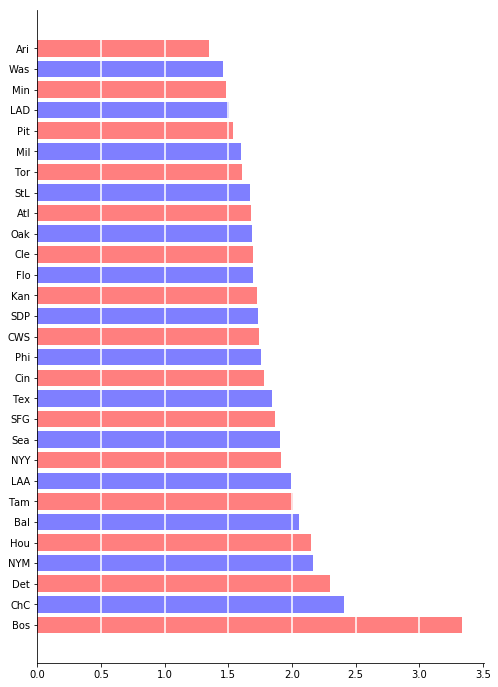

In [30]:
fig, ax = plt.subplots(figsize=(8,12))
ax.barh('home', 'RELSPRICE', data=team_rels, alpha=0.5, color=['red','blue']*15)
for i in [0.5*i for i in range(1,7)]:
    plt.axvline(x=i, color='white')
sns.despine()
plt.savefig('resells.pdf', bbox_inches='tight')
plt.show()

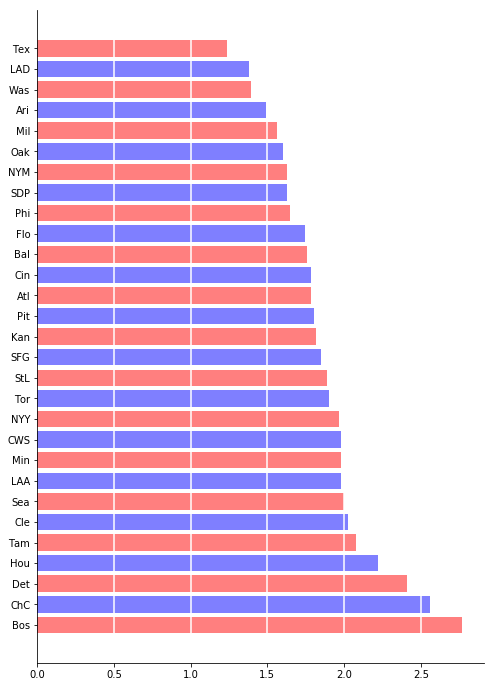

In [31]:
fig, ax = plt.subplots(figsize=(8,12))
ax.barh('home', 'RELSPRICE', data=team_relsC, alpha=0.5, color=['red','blue']*15)
for i in [0.5*i for i in range(1,6)]:
    plt.axvline(x=i, color='white')
sns.despine()
plt.savefig('resellsC.pdf', bbox_inches='tight')
plt.show()

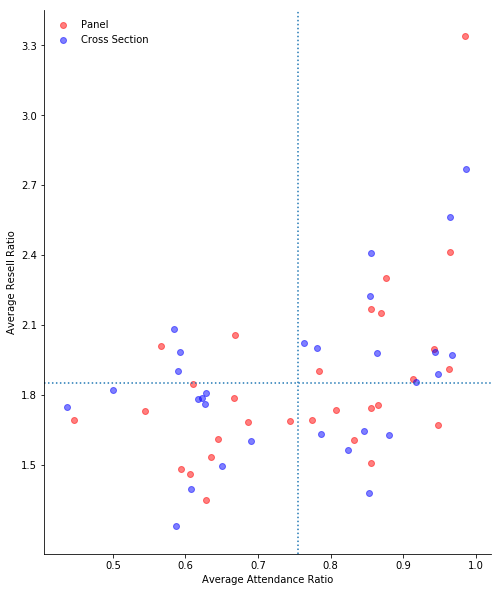

In [32]:
fig, ax = plt.subplots(figsize=(8,10))
ax.scatter('propmaxatt', 'RELSPRICE', data=crosses, color='red', alpha=0.5, label='Panel')
ax.scatter('propmaxatt', 'RELSPRICE', data=crossesC, color='blue', alpha=0.5, label='Cross Section')
plt.axvline(x=0.5*crosses['propmaxatt'].mean()+0.5*crossesC['propmaxatt'].mean(), linestyle=':')
plt.axhline(y=0.5*crosses['RELSPRICE'].mean()+0.5*crosses['RELSPRICE'].mean(), linestyle=':')
ax.set_yticks([0.3*i for i in range(5,12)])
ax.set_xlabel('Average Attendance Ratio')
ax.set_ylabel('Average Resell Ratio')
plt.legend(frameon=False)
sns.despine()
plt.savefig('scatter.pdf', bbox_inches='tight')
plt.show()